In [1]:
import h5py, os
import numpy as np
import matplotlib.pyplot as plt
import glob
from copy import deepcopy
from scipy.interpolate import interp1d
import json

In [2]:
cwd = os.getcwd()
dataset_name = "20260225_d250nm_two_defects"
res_dir = os.path.join(cwd, "Datagen_results", dataset_name)
h5_paths = glob.glob(os.path.join(res_dir, 'SCLC_Dataset*.h5'))
# Get voltage axis
exp_JV_filename = os.path.join(cwd, 'SIMsalabim', 'SimSS', 'exp_JV.csv')
voltage_axis = np.loadtxt(exp_JV_filename, skiprows=1)[:,0]

num_to_plot = 5

varied_parameters = {                                                       
    'W_L': (4.2, 4.5),  # Left defect position range                       
    'W_R': (4.2, 4.5),  # Right defect position range                      
    'E_d,sh': (4.22, 4.48),  # Defect energy range                          
    'N_t,sh': (1e22, 1e24),  # Defect density range                         
    'N_t,d': (1e20, 1e22),  # Defect density range                          
    'mu_e': (1e-8, 1e-6)    # electron mobility                             
}                                                                           
log_transform_items = ['N_t,sh', 'N_t,d', "mu_e"]                           
log_indices = [3,4,5]   
varied_parameters_log = deepcopy(varied_parameters)
for key in log_transform_items:
    if key in varied_parameters_log:
        varied_parameters_log[key] = tuple(np.log(val) for val in varied_parameters_log[key])  

In [3]:
input_all, output_all, feature_all = [], [], []
for h5_path in h5_paths:
    with h5py.File(h5_path, 'r') as hf:
        input_all.append(hf['inputs'][:])
        output_all.append(hf['outputs'][:])
        feature_all.append(hf.attrs['feature_names'])
input_all = np.concatenate(input_all)
output_all = np.concatenate(output_all)
feature_all = feature_all[0]
        
print(f"Dataset loaded. Total converged samples: {output_all.shape[0]}")

indices = np.random.choice(output_all.shape[0], num_to_plot, replace=False)

def plot_random_jv(outputs, voltage_axis, indices, save_path, log_mode=True):
    plt.figure(figsize=(8, 6))
        
    for idx in indices:
        # Extract J (Current) and the parameters for the legend
        jv_curve = outputs[idx]
        if log_mode:
            plt.plot(voltage_axis, jv_curve)
        else:
            plt.plot(jv_curve)

    if log_mode:
        plt.yscale('log')
        plt.xscale('log')
        plt.ylabel('Current Density $J$ ($A/m^2$)')
        name = ""
    else:
        plt.ylabel('Current Density log($J$) ($A/m^2$)')
        name = '_log'
    plt.xlabel('Voltage (V)')
    plt.title(f'Random Samples from {dataset_name}')
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.tight_layout()
        
    # Save the preview
    plt.savefig(os.path.join(save_path, f'random_jv{name}.png'), dpi=300)
    plt.show()

Dataset loaded. Total converged samples: 38305


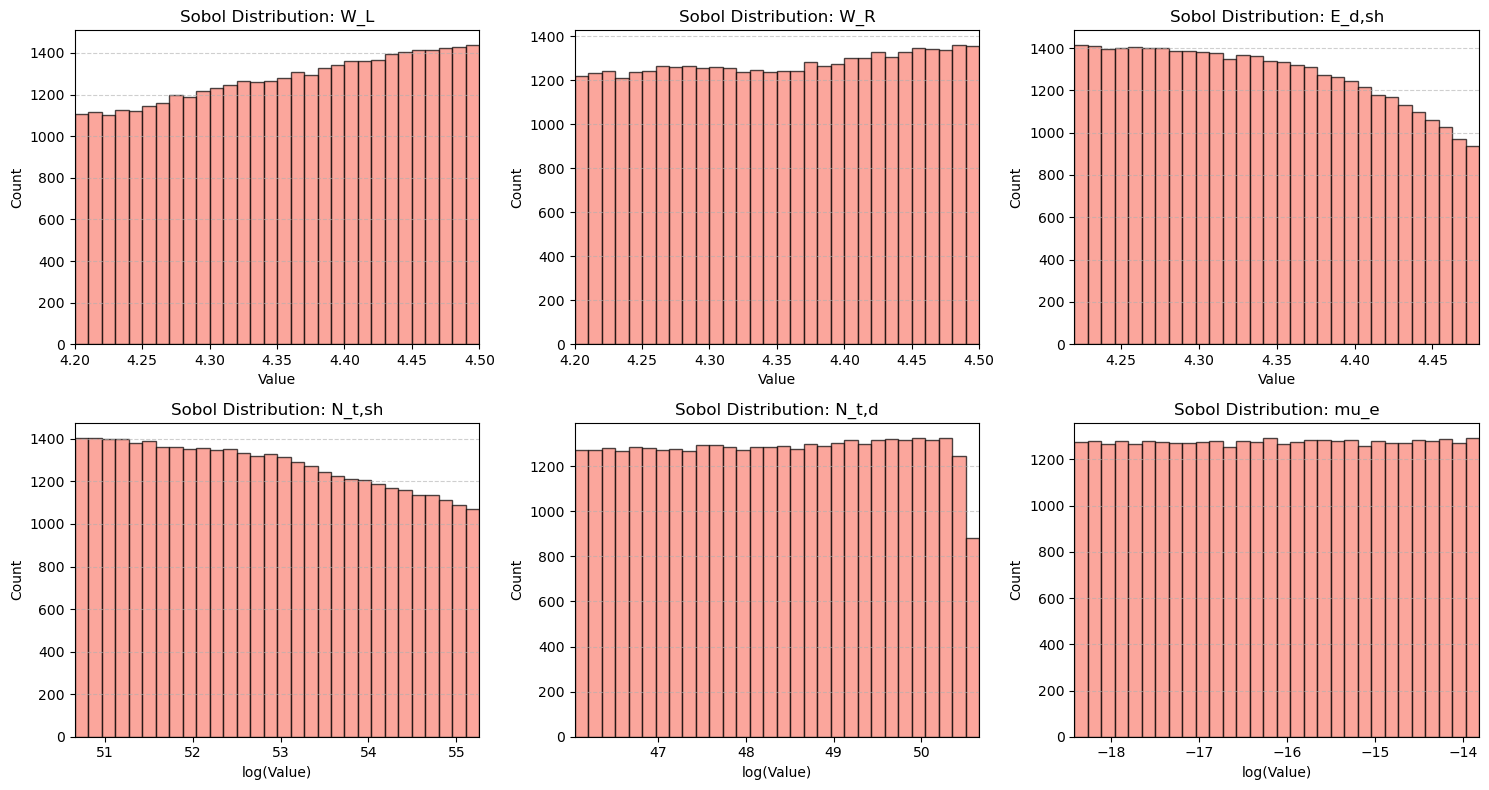

In [6]:
def plot_parameter_histograms(inputs, varied_log_dict, log_indices, save_path):
    param_names = list(varied_log_dict.keys())
    num_params = len(param_names)
    
    cols = 3
    rows = (num_params + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
    axes = axes.flatten()

    for i, name in enumerate(param_names):
        # Get boundaries from the log dictionary
        low, high = varied_log_dict[name]
        
        # Plot data
        if i in log_indices:
            axes[i].hist(np.log(inputs[:, i]), bins=30, color='salmon', edgecolor='black', alpha=0.7)
        else:
            axes[i].hist(inputs[:, i], bins=30, color='salmon', edgecolor='black', alpha=0.7)
        
        # Set x-limits strictly to the sampling boundaries
        axes[i].set_xlim(low, high)
        axes[i].set_title(f'Sobol Distribution: {name}')
        if i in log_indices:
            axes[i].set_xlabel('log(Value)')
        else:
            axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Count')
        axes[i].grid(axis='y', linestyle='--', alpha=0.6)

    # Clean up empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'parameter_coverage_check.png'), dpi=300)

plot_parameter_histograms(input_all, varied_parameters_log, log_indices, res_dir)

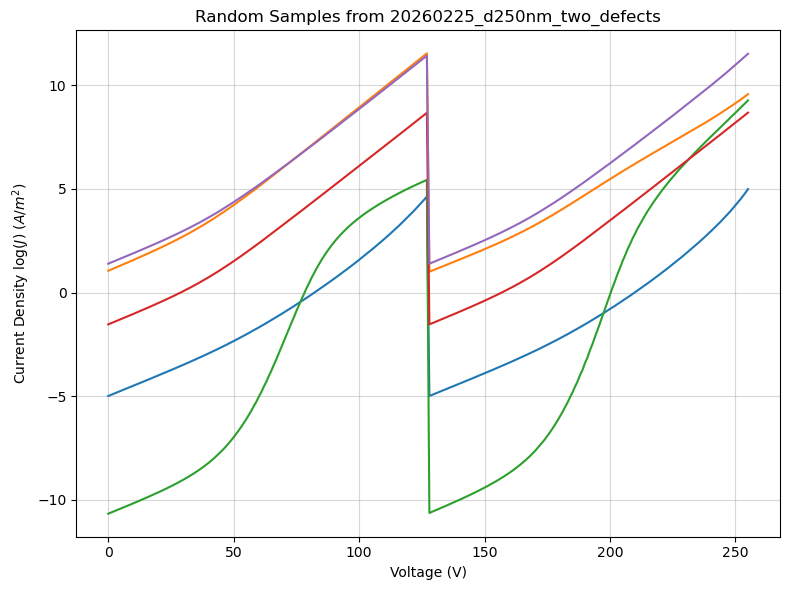

In [7]:
def preprocess_for_nn(v_sim, j_sim, target_v_start, target_v_end, target_points=128):
    """
    v_sim: original voltage array (e.g., -10 to 10)
    j_sim: original current density array
    """
    # 1. Define target grids
    v_fwd_target = np.logspace(np.log10(target_v_start), np.log10(target_v_end), target_points)
    v_rev_target = - v_fwd_target # Negative sequence
    
    # 2. Create Interpolation function
    # Using 'linear' or 'cubic'; linear is safer for simulation data
    interp_func = interp1d(v_sim, j_sim, kind='linear', fill_value="extrapolate")
    
    # 3. Interpolate
    j_fwd = interp_func(v_fwd_target)
    j_rev = interp_func(v_rev_target)
    
    j_combined = np.concatenate([j_fwd, j_rev])
    
    # 4. Transform: Absolute -> Log
    # Clip to avoid log(0) - adjust 1e-10 to your noise floor
    j_abs = np.abs(j_combined)
    j_log = np.log(np.clip(j_abs, 1e-10, None))
    
    return j_log

# Execute for all samples
target_v_start, target_v_end = 0.02, 10
combined_v_target = np.tile(np.logspace(np.log10(target_v_start), np.log10(target_v_end), 128), 2)
nn_outputs = np.array([preprocess_for_nn(voltage_axis, row, target_v_start, target_v_end) for row in output_all])
plot_random_jv(nn_outputs, voltage_axis, indices, res_dir, log_mode=False)
# Global Normalization
j_min, j_max = nn_outputs.min(), nn_outputs.max()
nn_outputs_scaled = (nn_outputs - j_min) / (j_max - j_min)

In [9]:
h5_final_path = os.path.join(res_dir, 'combined_SCLCdata.h5')

with h5py.File(h5_final_path, 'w') as hf:
    # Heavy arrays
    hf.create_dataset('input_all', data=input_all, compression="gzip")
    hf.create_dataset('nn_outputs', data=nn_outputs, compression="gzip")
    hf.create_dataset('nn_outputs_scaled', data=nn_outputs_scaled, compression="gzip")
    hf.create_dataset('combined_v_target', data=combined_v_target, compression="gzip")
    
    # Store global normalization constants as attributes for quick access
    hf.attrs['j_min_log'] = j_min
    hf.attrs['j_max_log'] = j_max

metadata = {
    'j_min': float(j_min), # Ensure these are standard floats, not numpy floats
    'j_max': float(j_max),
    'varied_parameters': varied_parameters,
    'varied_parameters_log': varied_parameters_log,
    'log_transform_items': log_transform_items,
    'log_indices': [int(i) for i in log_indices], # Convert to standard int for JSON
    'target_v_start' : float(target_v_start),
    'target_v_end' : float(target_v_end)
}

json_path = os.path.join(res_dir, 'simulation_metadata.json')

with open(json_path, 'w') as f:
    json.dump(metadata, f, indent=4)